In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import tensorflow as tf
import numpy as np
import random as rn

seed = 0 # Here sd means seed.
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

from keras import backend as K
config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=config)
K.set_session(sess)

/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jorge/anaconda3/

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from tensorflow.keras import initializers

from keras.callbacks import EarlyStopping

 

#from tensorflow.keras.layers import Attention
#from attention_decoder import AttentionDecoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import max_error
import seaborn as sns
from keras.callbacks import History 
from sklearn.model_selection import KFold 
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit

In [4]:
path = os.getcwd()
folder = path+"/dataset/ts_jorge_2800_3L/"
print(folder)

/home/jorge/tsunami-warning/dataset/ts_jorge_2800_3L/


In [5]:
boya_x = 14
boya_y = 29

df_x = pd.read_json(folder+'DataFrame_boya-'+str(boya_x)+'-3L.json') # cargar dataframe
df_y = pd.read_json(folder+'DataFrame_boya-'+str(boya_y)+'-3L.json') # cargar dataframe

In [6]:
index = pd.date_range('25/8/2020', periods=len(df_x), freq='10S')
Datetime = pd.DataFrame({'Datetime':index})

In [7]:
df_x = pd.concat([Datetime, df_x], axis=1,)
df_y = pd.concat([Datetime, df_y], axis=1,)

## Generación de Grupos (Inunda- No Inunda)

In [8]:
indexC = df_y.columns
len(indexC)

2789

In [9]:
Inu = []
inu = {}
NoInu = []
c = -1
groups = []
for i in indexC:
    if i.startswith("boyas"+str(boya_y)):
        c+=1
        if df_y[i].max()>0:
            groups.append(1)
            Inu.append(c)
            inu[i] = [df_y[i].max()]
        else:
            NoInu.append(c)
            groups.append(0)

In [10]:
df_x = df_x.loc[0:180*1]# solo la primera 0.5 hora de registro
df_y = df_y.loc[0:180*1]# solo la primera 0.5 hora de registro

In [11]:
df_x.describe()

,boyas14_ts0000,boyas14_ts0001,boyas14_ts0002,boyas14_ts0003,boyas14_ts0004,boyas14_ts0005,boyas14_ts0006,boyas14_ts0007,boyas14_ts0008,boyas14_ts0009,...,boyas14_ts2790,boyas14_ts2791,boyas14_ts2792,boyas14_ts2793,boyas14_ts2794,boyas14_ts2795,boyas14_ts2796,boyas14_ts2797,boyas14_ts2798,boyas14_ts2799
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,...,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,-0.492480,0.507394,-2.011207,-0.054610,0.030263,-0.373332,-0.504375,-0.856791,-0.077619,0.152410,...,3.076605,0.947836,0.463505,-1.480160,0.408618,-0.533419,-0.018418,-3.381489,-0.827312,-0.649918
std,0.463236,0.501607,1.448863,0.264177,0.134734,0.251610,0.480279,0.674131,1.024499,0.134323,...,3.906991,0.852627,1.756684,3.321676,1.424531,1.838447,1.246908,5.201241,0.865543,2.092550
min,-1.203184,-0.219757,-3.897851,-0.808506,-0.189814,-0.762288,-1.184207,-1.852629,-2.094189,-0.000837,...,-3.107658,0.000000,-3.286161,-8.102111,-2.491845,-4.610311,-2.337385,-12.266755,-2.932384,-5.189206
25%,-1.009395,0.093586,-3.574881,-0.051238,-0.055858,-0.589425,-1.009184,-1.510336,-1.092439,0.012968,...,0.062575,0.061871,-0.092177,-5.127423,-0.003211,-0.506973,-0.693605,-9.778997,-1.170463,-1.044742
50%,-0.497093,0.303034,-2.182099,-0.004463,-0.004131,-0.377343,-0.480148,-0.731690,0.111206,0.141714,...,2.060990,0.847772,0.011117,0.055272,0.081120,-0.004048,-0.121978,0.001450,-0.688325,-0.250988
75%,0.000686,1.077469,-0.458622,0.066768,0.166682,-0.103034,0.000447,-0.124393,0.884531,0.271775,...,6.325341,1.642859,1.241768,0.815443,1.756988,0.278640,0.140996,0.483000,-0.097501,0.900255
max,0.054347,1.390274,0.000000,0.537046,0.400259,0.000000,0.058541,0.000000,1.184284,0.473172,...,11.796312,2.861938,5.615876,3.115929,3.000306,2.204457,4.116798,2.271048,0.789283,3.094444


In [12]:
df_x = df_x.resample('10S', on='Datetime').mean()
df_y = df_y.resample('10S', on='Datetime').mean()

Text(0, 0.5, 'Altura de ola [m]')

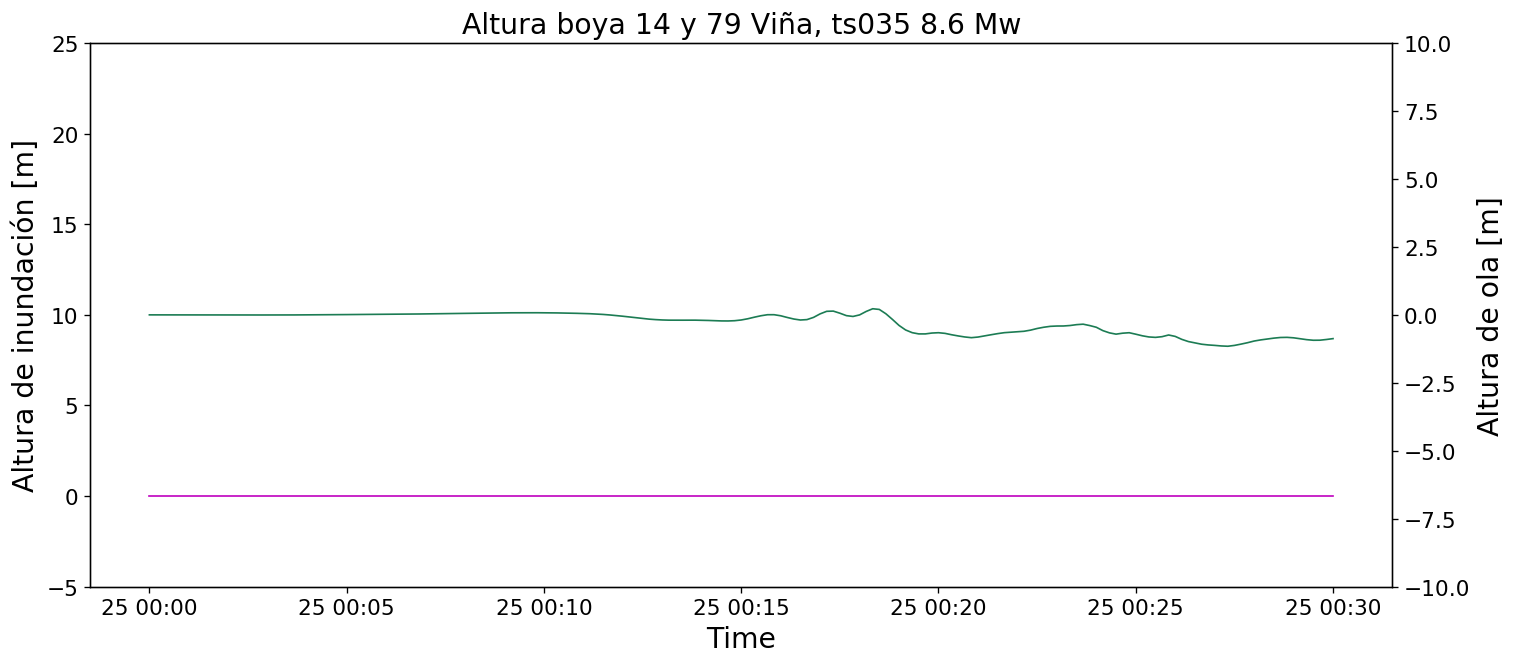

In [13]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 79 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df_y['boyas'+str(boya_y)+'_ts0126'], color='m', linewidth=1.0)
plt.ylim(-5,25)
plt.twinx()
plt.plot(df_x['boyas'+str(boya_x)+'_ts0126'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)

In [14]:
df_x = df_x.resample('T').max()
df_y = df_y.resample('T').max()

Text(0, 0.5, 'Altura de ola [m]')

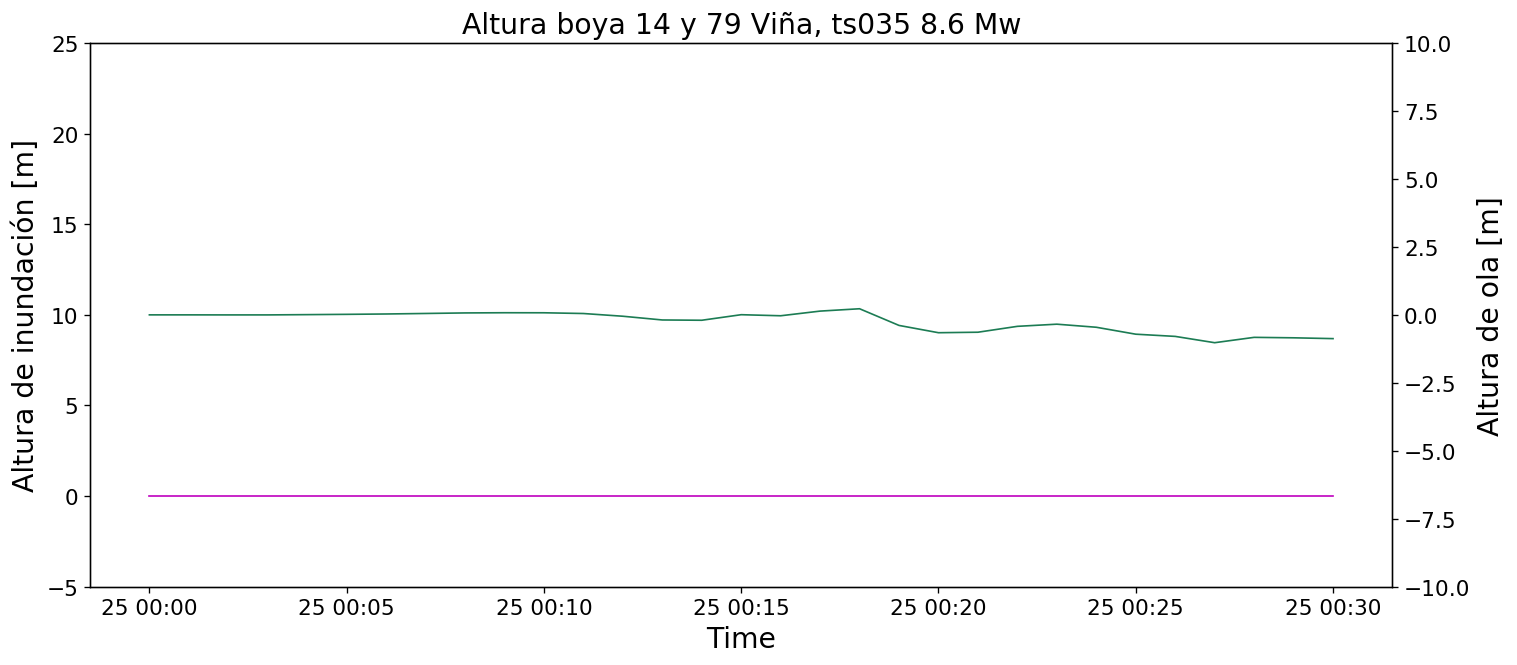

In [15]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 79 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df_y['boyas'+str(boya_y)+'_ts0126'], color='m', linewidth=1.0)
plt.ylim(-5,25)
plt.twinx()
plt.plot(df_x['boyas'+str(boya_x)+'_ts0126'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)

In [16]:
print('Escenarios que inundan',len(Inu))
print('Escenarios que no inundan',len(NoInu))

Escenarios que inundan 716
Escenarios que no inundan 2072


In [17]:
df_x = df_x.values.astype('float32')
df_y = df_y.values.astype('float32')

In [18]:
#data_pre_train, data_pre_temp = train_test_split(data, test_size= 0.5)
#data_pre_val, data_pre_test = train_test_split(data_pre_temp, test_size= 0.4)

#scaler = StandardScaler().fit(df)
#df= scaler.transform(df)
#df= pd.DataFrame(scaler.transform(df),
 #                                columns=df.columns)


In [19]:
#xtest = df.pop('boyas14_ts035') # asigna y quita columna
#ytest = df.pop('boyas101_000126') # asigna y quita columna

In [20]:
#df = df.values.astype('float32')
#xtest = xtest.values.astype('float32')
#ytest = ytest.values.astype('float32')

In [21]:
# genera secuencias de entrada y salida
def split_sequence(df):
    X = list()
    for time in range(0,df.shape[1],1):
        # se suma uno porque no considera el ultimo
        seq_x = df[:,time]
        X.append(seq_x)
        
    return np.array(X)


In [22]:
trainX = split_sequence(df_x)
trainY = split_sequence(df_y)
#testX,testY = xtest,ytest

In [23]:
trainY.shape

(2788, 31)

In [24]:
n_features = 1
n_steps = trainX.shape[1]
print('n_steps :',n_steps)

n_steps : 31


In [25]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))


In [26]:
trainX.shape

(2788, 31, 1)

In [27]:
trainY.shape

(2788, 31)

**comentario :** Etiquetas para diferencias las escenarios que **Si inundan** y los que **No indundan**, debido a lo desbalanceada que esta la data aproximadamente solo el 18% de los escenarios inundan. 

## Train-Validation-Test.
Separar datos de forma balanceda.

In [28]:
from sklearn.model_selection import train_test_split
SiInu_id = []
NoInu_id = []
cont = -1
for i in groups:
    cont+=1
    if i ==0:
        NoInu_id.append(cont)
        
    if i ==1:
        SiInu_id.append(cont)

y_train, y_val = train_test_split(SiInu_id, test_size=0.3, random_state=42)
x_train, x_val = train_test_split(NoInu_id, test_size=0.3, random_state=42)

y_val, y_test = train_test_split(y_val, test_size=0.33, random_state=42)
x_val, x_test = train_test_split(x_val, test_size=0.33, random_state=42)

x_train+=y_train
x_val+=y_val
x_test+=y_test

np.random.shuffle(x_train) # indices de train balanceados y desordenados
np.random.shuffle(x_val) # indices de validation balanceados y desordenados
np.random.shuffle(x_test) # indices de validation balanceados y desordenados

In [29]:
total = len(groups)


In [30]:
print('% Datos de train: ',len(x_train)/total)
print('% Datos de validation: ',len(x_val)/total)
print('% Datos de test: ',len(x_test)/total)

% Datos de train:  0.6997847919655668
% Datos de validation:  0.20086083213773315
% Datos de test:  0.09935437589670014


## CNN 1-D.

In [31]:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)

In [32]:
filtros = [256,128]
kernel = [9]
activations = ['relu','tanh']
lrr = [0.001,0.0001]
batch = [8,12,16,18,20]
dropoutt = [0.1,0.2,0.3]

In [33]:
import time
Best_model = {}
Error = 1000
Error_val = []
start2 = time.time()
for f in filtros:
    print('tamaño filtro',f)
    for k in kernel:
        print(k)
        for act in activations:
            print(act)
            for l in lrr:
                print(l)
                for b in batch:
                    print(b)
                    for d in dropoutt:
                        
                        print(d)


                        epoch = 1000
                        Xm = trainX
                        ym = trainY
                        #skf = StratifiedKFold(n_splits=2,shuffle=True)#,random_state=42)
                        #skf.get_n_splits(Xm, groups)


                        hist = History()
                        model = Sequential()
                        model.add(Conv1D(filters=f, kernel_size=k,#kernel_initializer=initializer, bias_initializer=bias_ini,
                                         activation='relu', input_shape=(n_steps, n_features)))
                        model.add(Conv1D(filters=int(f/2), kernel_size=int(k-3),#kernel_initializer=initializer,bias_initializer=bias_ini,
                                 activation='relu'))

                        model.add(Conv1D(filters=int(f/4), kernel_size=int(k-6),#kernel_initializer=initializer,bias_initializer=bias_ini,
                                 activation='relu'))

                        #model.add(Conv1D(filters=8, kernel_size=3,#kernel_initializer=initializer,bias_initializer=bias_ini,
                         #        activation='relu'))

                        model.add(BatchNormalization())

                        model.add(MaxPooling1D(pool_size=2))

                        model.add(Flatten())

                        model.add(Dense(90,#kernel_initializer=initializer,bias_initializer=bias_ini, 
                                        activation=act))

                        model.add(Dropout(d, seed = seed))

                        model.add(Dense(60,#kernel_initializer=initializer,bias_initializer=bias_ini, 
                                        activation=act))

                        model.add(Dropout(0.1, seed = seed))

                        model.add(Dense(n_steps,#kernel_initializer=initializer,bias_initializer=bias_ini, 
                                        activation='relu'))
                        #
                        model.compile(optimizer=Adam(lr=l), loss='mse')



                        start = time.time()
                        #for train, test in gss.split(Xm, ym, groups): #tscv.split(Xm):

                        train = x_train
                        val = x_val
                        #print('train',train)
                        #print('test',val)
                        history = model.fit(Xm[train], ym[train],validation_data=(Xm[val], ym[val]), epochs=epoch,
                                                batch_size=b, verbose=0,callbacks=[es])
                            #break
                        end = time.time()

                        print('time execution',(end - start)/60)
                        error_val = min(history.history['val_loss'])
                        Error_val.append(error_val)
                        print('Error val',error_val)
                        if error_val < Error:
                            Error = error_val
                            Best_model['filtros'] = f
                            Best_model['kernel'] = k
                            Best_model['activation'] = act
                            Best_model['learning'] = l
                            Best_model['batch_size'] = b
                            Best_model['Error val'] = Error
                            Best_model['drop_out'] = d

end2 = time.time()                        
print('time execution grid search',(end2 - start2)/60)                        

tamaño filtro 256
9
relu
0.001
8
0.1


Epoch 00058: early stopping
time execution 2.681616449356079
Error val 0.011454667076889434
0.2
Epoch 00032: early stopping
time execution 1.5662262916564942
Error val 0.023400519934641904
0.3
Epoch 00054: early stopping
time execution 2.7092031518618267
Error val 0.01272084933352744
12
0.1
Epoch 00055: early stopping
time execution 2.026841123898824
Error val 0.010621865947385751
0.2
Epoch 00048: early stopping
time execution 1.8478528261184692
Error val 0.01759649200705878
0.3


KeyboardInterrupt: 

In [ ]:
Best_model

**Comentario : Mejor función de activación ReLu, Sigmoide y linear 3 veces mayor error.**

In [ ]:
min(history.history['val_loss'])

In [ ]:
import matplotlib.pyplot as plt
a=np.linspace(1,epoch,epoch)
plt.figure(figsize=(24,4), dpi=100)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.subplot(1,2,1)
plt.plot(history.history['val_loss'],'r.',label = 'Validation')
plt.plot(history.history['loss'],'g.',label = 'Train')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.legend(loc='upper right')

## Datos de test.

In [ ]:
Xm = trainX
ym = trainY
test = x_test
Xtest = Xm[test]
ytest = ym[test]

In [ ]:
Xtest.shape[0]

In [ ]:
plt.figure(figsize=(18,8), dpi=100)

for i in range(int(Xtest.shape[0]/4)) :
    #plt.figure(figsize=(18,8), dpi=100)
    x_test=Xtest[i].reshape((1,n_steps,1))
    testPredict = (model.predict(x_test)).reshape(-1,1)
    plt.plot(ytest[i],label = 'real')
    plt.plot(testPredict,'--', label = 'simulado')
    #plt.plot(testY,label = 'real test')
    #plt.plot(testPredict, label = 'simulado test')
    plt.rc('xtick', labelsize=17) 
    plt.rc('ytick', labelsize=17)
    plt.title('Altura de inundación Viña boya 120',fontsize=17)
    plt.ylabel('Altura [m]',fontsize=17)
    plt.xlabel('Tiempo [min]',fontsize=17)
    plt.legend(loc='upper left',fontsize=13)
    #testX=testX.reshape((1,n_steps,1))

- buscar metrica que penalice mas el error de los maximos.
- buscar split que realice una separacion mas balanceada.
- probar modelo convolucional 1D. con atencion.
- transfer learning con autoencoder.
- capa attention en lstm

In [ ]:
len(x_test)